# Monte Carlo Tree Search


Ein beliebter Algorithmus, der in vielen Programmen (z.B. AlphaGoZero) Anwendung findet.

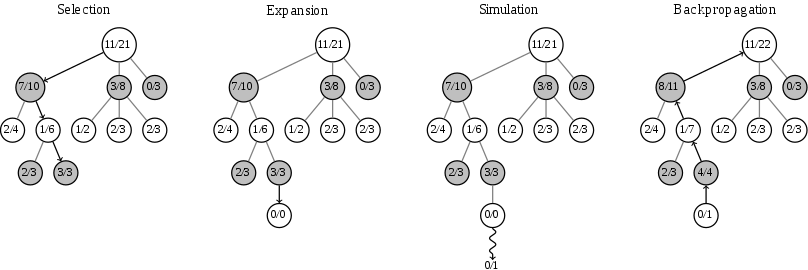

Jeder Knoten in dem Baum repräsentiert einen ausgeführten Spielzug und hat eine Liste von Zügen die von dort aus noch möglich sind. Desweiteren hat jeder Knoten noch einen Wert und eine Besuchsanzahl.

Der Algorithmus besteht aus 4 Schritten die beliebig oft wiederholt werden:

1. Selection: Von der Wurzel aus werden mithilfe eines Auswahlalgorithmus Nachfolger ausgewählt bis man an einem Blatt ist
2. Expansion: An der Ausgewählten Stelle wird ein neuer Knoten an den Baum angehängt
3. Simulation: Das Spiel wird (zufällig) von dem gewählten Knoten (und damit Spielzug) aus zuende gesppielt (daher auch Monte-Carlo rollout genannt)
4. Backpropagation: Von den Knoten aus wird das Ergebnis an die ewieligen Vorgänger bis hin in die Wurzel weitergegeben

Danach wird mithilfe eines weiteren Auswahlalgorithmus ein Nachfolger der Wurzel gewählt die den besten Zug repräsentiert.

Der Wert der Knoten ergibt sich aus dem durschnittlichen Wert der Nachfolger

In [1]:
"""
Inspiriert von http://mcts.ai/code/python.html
"""

from Player import ValuePlayer
import random
import math

class Node:
    
    #Erzeugt einen neuen Knoten
    def __init__(self, move = None, parent = None, actions = None, player = None, value = None):
        self.move = move
        self.parentNode = parent
        self.childNodes = []
        self.wins = 0
        self.visits = 0
        self.untriedMoves = list(actions)
        self.playerJustMoved = player
        self.function_value = value
        
    #Wendet die UCB1 Formel an um den besten Knoten zu finden
    def UCTSelectChild(self):
        s = sorted(self.childNodes, key = lambda c: c.wins/c.visits + math.sqrt(2*math.log(self.visits)/c.visits))[-1]
        return s
    
    #Hängt einen neuen Knoten an den Baum mit diesem Knoten als Vaterknoten
    def AddChild(self, m, a, p, v):
        n = Node(move = m, parent = self, actions = a, player = p, value = v)
        self.untriedMoves.remove(m)
        self.childNodes.append(n)
        return n
    
    #Updated die Statistik
    def Update(self, result):
        self.visits += 1
        self.wins += result
        
    # Berechnet den Wert des Knoten aus dem durschnittlichen Wert der Nachfolger
    def get_value(self):
        val = 0
        for c in self.childNodes:
            val += c.get_value()
        # Keine Nachfolger
        if val == 0:
            return self.function_value
        # Durchschnitt berechnen
        return val / len(self.childNodes)

class MCTSValuePlayer(ValuePlayer):
    
    def get_action(self, actions, game):
        return self.MCTS(actions, game, 5000)

    def MCTS(self, actions, rootgame, itermax):
        #Erstellt die Wurzel
        rootnode = Node(actions = actions, player = self.player)

        #Solange wie man Geduld hat wird ein baum erstellt, erweitert und Spiele zufällig zuende gespielt,
        #um am Ende den am meisten besuchten Knoten zurückzugeben
        for i in range(itermax):
            #Zur Wurzel zurückgehen und das Spiel zurück in den ausgangszustand bringen
            node = rootnode
            game = rootgame.Clone()

            #Phase 1: Selection. Sucht ein geeignetes Blatt mit dem UCB1 Algorithmus
            while node.untriedMoves == [] and node.childNodes != []:
                node = node.UCTSelectChild()
                #Bringt das Spiel in den jeweils zugehörigen Zustand
                game.execute_moves(node.move, game.get_opponent(node.playerJustMoved))

            #Phase 2: Expansion. Hängt den von der value-function als besten Zug bezeichneten Zug an den Baum an
            if node.untriedMoves != []:
                #Value-function fragen was wir denn nehmen sollten!
                #m = ValuePlayer.get_action(self, node.untriedMoves, game) 
                m = random.choice(node.untriedMoves)
                #Daten für neuen Knoten sammeln
                game.execute_moves(m, node.playerJustMoved)
                value = self.value(game, self.player)
                next_player = game.get_opponent(node.playerJustMoved)
                #Einmal Würfeln und Züge besorgen
                next_actions = []
                roll = (random.randint(1,6), random.randint(1,6))
                rolls = [(i,j) for i in range(1,7) for j in range(i,7)]
                for roll in rolls:
                    next_actions.extend(game.get_moves(roll, next_player))
                #Neuen Knoten erzeugen und anhängen
                node = node.AddChild(m, next_actions, next_player, value)

            #Phase 3: Simulation. Spielt das Spiel von dem gewählten Knoten aus zufällig zuende und ermittelt dem Gewinner
            winner = game.play_random_fast(node.playerJustMoved)
            
            #Phase 4: Backpropagation. Update alle Vaterknoten bis hin zu Wurzel und erhöhe ggf. den Siegeszähler
            while node != None:
                #Siegeszähler deren Knoten erhöhen die den Sieger als Spieler eingetragen haben
                result = 1 if winner == node.playerJustMoved else 0
                node.Update(result)
                node = node.parentNode
                
        #Baum Statistik
        #print(rootnode.childNodes, len(rootnode.childNodes), len(actions))
        #Denjenigen Nachfolger von der Wurzel nehmen, der am meisten besucht wurde
        rootchilds = sorted(rootnode.childNodes, key = lambda c: c.get_value())
        best_move = rootchilds[-1].move
        #self.print_tree(rootnode)
        return best_move
    
    def get_value(self, action, game):
        old_state = game.get_state()
        # Zug ausführen
        game.execute_moves(action, self.player)
        # Spielstatus bewerten
        value = self.value(game, self.player)
        # Spiel zurücksetzen
        game.reset_to_state(old_state)
        return value
    
    def print_tree(self, root):
        print(root.move, root.visits, root.wins, root.function_value, root.get_value())
        for c in root.childNodes:
            print("->", c.move, c.visits, c.wins, c.function_value, c.get_value())
    
        
    def get_name(self):
        return "MCTSValuePlayer [" + self.value.__name__ + "]"
        
class MCTSModelPlayer(MCTSValuePlayer):
    
    def __init__(self, player, model):
        MCTSValuePlayer.__init__(self, player, self.get_model_value)
        self.model = model
        
    def get_model_value(self, game, player):
        features = game.extractFeatures(player)
        v = self.model.get_output(features)
        v = 1 - v if self.player == game.players[0] else v
        return v
    
    def get_name(self):
        return "MCTSModelPlayer [" + self.model.get_name() +"]"

In [5]:
import Player
import PlayerTest

players = [Player.ValuePlayer('black', Player.singleton), MCTSValuePlayer('white', Player.singleton)]

PlayerTest.test(players, 100)

Spiel 0 von 100 geht an ValuePlayer [singleton] ( black )
Spiel 1 von 100 geht an ValuePlayer [singleton] ( black )
Spiel 2 von 100 geht an MCTSValuePlayer [singleton] ( white )
Spiel 3 von 100 geht an MCTSValuePlayer [singleton] ( white )
Spiel 4 von 100 geht an ValuePlayer [singleton] ( black )
Spiel 5 von 100 geht an ValuePlayer [singleton] ( black )
Spiel 6 von 100 geht an ValuePlayer [singleton] ( black )
Spiel 7 von 100 geht an ValuePlayer [singleton] ( black )
Spiel 8 von 100 geht an MCTSValuePlayer [singleton] ( white )
Spiel 9 von 100 geht an MCTSValuePlayer [singleton] ( white )
Spiel 10 von 100 geht an MCTSValuePlayer [singleton] ( white )
Spiel 11 von 100 geht an ValuePlayer [singleton] ( black )
Spiel 12 von 100 geht an ValuePlayer [singleton] ( black )
Spiel 13 von 100 geht an ValuePlayer [singleton] ( black )
Spiel 14 von 100 geht an MCTSValuePlayer [singleton] ( white )
Spiel 15 von 100 geht an MCTSValuePlayer [singleton] ( white )
Spiel 16 von 100 geht an ValuePlayer [

Keine Verbesserung für Singleton.

### TD-Gammon vs. TD-Gammon mit MCTS

In [2]:
import Player
import PlayerTest
import tensorflow as tf
from NeuralNetModel import TDGammonModel

graph = tf.Graph()
sess = tf.Session(graph=graph)
with sess.as_default(), graph.as_default():
    model = TDGammonModel(sess, restore=True)
    players = [Player.ModelPlayer('black', model), MCTSModelPlayer('white', model)]
    PlayerTest.test(players, games=10)

Restoring checkpoint: checkpoints/TD-Gammon/checkpoint.ckpt-1593683
INFO:tensorflow:Restoring parameters from checkpoints/TD-Gammon/checkpoint.ckpt-1593683
Spiel 0 von 10 geht an ModelPlayer [TD-Gammon] ( black )
Spiel 1 von 10 geht an MCTSModelPlayer [TD-Gammon] ( white )
Spiel 2 von 10 geht an MCTSModelPlayer [TD-Gammon] ( white )
Spiel 3 von 10 geht an ModelPlayer [TD-Gammon] ( black )
Spiel 4 von 10 geht an MCTSModelPlayer [TD-Gammon] ( white )
Spiel 5 von 10 geht an MCTSModelPlayer [TD-Gammon] ( white )
Spiel 6 von 10 geht an ModelPlayer [TD-Gammon] ( black )
Spiel 7 von 10 geht an MCTSModelPlayer [TD-Gammon] ( white )
Spiel 8 von 10 geht an ModelPlayer [TD-Gammon] ( black )
Spiel 9 von 10 geht an MCTSModelPlayer [TD-Gammon] ( white )

{'black': 4, 'white': 6}
ModelPlayer [TD-Gammon] vs. MCTSModelPlayer [TD-Gammon] : 40.0 %
10 Spiele in  5496.06069111824 Sekunden


Leichte Verbesserung für TD-Gammon.

### TD-Gammon80 vs. TD-Gammon80 mit MCTS

In [3]:
from NeuralNetModel import TDGammonModel
import tensorflow as tf
import Player

graph = tf.Graph()
sess = tf.Session(graph=graph)
with sess.as_default(), graph.as_default():
    model = TDGammonModel(sess, hidden_size = 80, name = "TD-Gammon80", restore=True)
    players = [Player.ModelPlayer('black', model), MCTSModelPlayer('white', model)]
    PlayerTest.test(players, games=10)

Restoring checkpoint: checkpoints/TD-Gammon80/checkpoint.ckpt-1527600
INFO:tensorflow:Restoring parameters from checkpoints/TD-Gammon80/checkpoint.ckpt-1527600
Spiel 0 von 10 geht an ModelPlayer [TD-Gammon] ( black )
Spiel 1 von 10 geht an ModelPlayer [TD-Gammon] ( black )
Spiel 2 von 10 geht an ModelPlayer [TD-Gammon] ( black )
Spiel 3 von 10 geht an ModelPlayer [TD-Gammon] ( black )
Spiel 4 von 10 geht an MCTSModelPlayer [TD-Gammon] ( white )
Spiel 5 von 10 geht an ModelPlayer [TD-Gammon] ( black )
Spiel 6 von 10 geht an ModelPlayer [TD-Gammon] ( black )
Spiel 7 von 10 geht an ModelPlayer [TD-Gammon] ( black )
Spiel 8 von 10 geht an MCTSModelPlayer [TD-Gammon] ( white )
Spiel 9 von 10 geht an ModelPlayer [TD-Gammon] ( black )

{'black': 8, 'white': 2}
ModelPlayer [TD-Gammon] vs. MCTSModelPlayer [TD-Gammon] : 80.0 %
10 Spiele in  4948.879707574844 Sekunden


TD-Gammon80 spielt bereits so gut, dass das Negative überwiegt und der Informationsgewinn kleiner ist als die Störung durch den Zufall.

### TD-Gammon mit MCTS vs. TD-Gammon80

In [4]:
import Player
from NeuralNetModel import TDGammonModel

graph = tf.Graph()
sess = tf.Session(graph=graph)
with sess.as_default(), graph.as_default():
    model = TDGammonModel(sess, restore=True)
    graph2 = tf.Graph()
    sess2 = tf.Session(graph=graph2)
    with sess2.as_default(), graph2.as_default():
        model2 = TDGammonModel(sess2, hidden_size = 80, name = "TD-Gammon80", restore=True)
        players = [MCTSModelPlayer('black', model), Player.ModelPlayer('white', model2)]
        PlayerTest.test(players, games=10)

Restoring checkpoint: checkpoints/TD-Gammon/checkpoint.ckpt-1593683
INFO:tensorflow:Restoring parameters from checkpoints/TD-Gammon/checkpoint.ckpt-1593683
Restoring checkpoint: checkpoints/TD-Gammon80/checkpoint.ckpt-1527600
INFO:tensorflow:Restoring parameters from checkpoints/TD-Gammon80/checkpoint.ckpt-1527600
Spiel 0 von 10 geht an MCTSModelPlayer [TD-Gammon] ( black )
Spiel 1 von 10 geht an ModelPlayer [TD-Gammon] ( white )
Spiel 2 von 10 geht an ModelPlayer [TD-Gammon] ( white )
Spiel 3 von 10 geht an ModelPlayer [TD-Gammon] ( white )
Spiel 4 von 10 geht an ModelPlayer [TD-Gammon] ( white )
Spiel 5 von 10 geht an MCTSModelPlayer [TD-Gammon] ( black )
Spiel 6 von 10 geht an MCTSModelPlayer [TD-Gammon] ( black )
Spiel 7 von 10 geht an ModelPlayer [TD-Gammon] ( white )
Spiel 8 von 10 geht an ModelPlayer [TD-Gammon] ( white )
Spiel 9 von 10 geht an ModelPlayer [TD-Gammon] ( white )

{'black': 3, 'white': 7}
MCTSModelPlayer [TD-Gammon] vs. ModelPlayer [TD-Gammon] : 30.0 %
10 Spiele i

TD-Gammon80 ist einfach zu gut,